In [11]:
from visualization_tools import *
import pandas as pd
import json
import re
params = {"GRAMMAR": 'architecture_layer_type'}
def trim_phenotype(phenotype):
    if "shape" in phenotype:
        phenotype = phenotype.replace(", shape=shape, dtype=tf.float32", "")
        phenotype = phenotype.replace("tf.math.", "")
        phenotype = phenotype.replace("tf.", "")
        if 'architecture_layer_type' in params['GRAMMAR']:
            print("THIS IS A LAYER TYPE GRAMMAR")
            functions = phenotype.split(r'lambda is_dense, units, is_pool, pool_size, is_conv, kernel_size, filters, stride, layer_count, layer_num, shape, alpha')
        elif 'architecture' in params['GRAMMAR']:
            print("THIS IS AN ARCHITECTURAL GRAMMAR")
            functions = phenotype.split(r'lambda layer_count, layer_num, shape, alpha')
        else:
            print("THIS IS NOT AN ARCHITECTURAL GRAMMAR")
            functions = phenotype.split(r'lambda shape, alpha')

    elif "size" in phenotype:
        phenotype = phenotype.replace(", size=size, dtype=torch.float32", "")
        phenotype = phenotype.replace("torch.", "")        
        functions = phenotype.split(r'lambda size, alpha')
    
    #else:
    #    raise Exception()

    return functions 
def make_latex(string):
    string.replace()
phen = "alpha_func, beta_func, sigma_func, grad_func = lambda is_dense, units, is_pool, pool_size, is_conv, kernel_size, filters, stride, layer_count, layer_num, shape, alpha, grad: tf.math.subtract(grad, tf.math.divide_no_nan(tf.math.subtract(tf.math.add(grad, tf.math.multiply(is_dense, units)), grad), tf.constant(9.10782940e-01, shape=shape, dtype=tf.float32))), lambda is_dense, units, is_pool, pool_size, is_conv, kernel_size, filters, stride, layer_count, layer_num, shape, alpha, beta, grad: tf.math.add(tf.math.multiply(grad, tf.math.multiply(is_dense, units)), tf.math.pow(layer_count, tf.math.multiply(is_conv, kernel_size))), lambda is_dense, units, is_pool, pool_size, is_conv, kernel_size, filters, stride, layer_count, layer_num, shape, alpha, beta, sigma, grad: grad, lambda is_dense, units, is_pool, pool_size, is_conv, kernel_size, filters, stride, layer_count, layer_num, shape, alpha, beta, sigma, grad: tf.math.divide_no_nan(sigma, tf.math.add(tf.math.divide_no_nan(tf.constant(9.95290886e-01, shape=shape, dtype=tf.float32), tf.math.add(tf.math.negative(tf.constant(1.24647146e-04, shape=shape, dtype=tf.float32)), tf.math.multiply(tf.math.multiply(is_pool, pool_size), tf.math.sqrt(tf.math.subtract(sigma, tf.math.pow(beta, tf.math.add(tf.constant(9.38616893e-01, shape=shape, dtype=tf.float32), tf.math.multiply(layer_num, tf.math.square(layer_count))))))))), beta))"
trim_phenotype(phen)


alpha_func, beta_func, sigma_func, grad_func = lambda is_dense, units, is_pool, pool_size, is_conv, kernel_size, filters, stride, layer_count, layer_num, shape, alpha, grad: tf.math.subtract(grad, tf.math.divide_no_nan(tf.math.subtract(tf.math.add(grad, tf.math.multiply(is_dense, units)), grad), tf.constant(9.10782940e-01, shape=shape, dtype=tf.float32))), lambda is_dense, units, is_pool, pool_size, is_conv, kernel_size, filters, stride, layer_count, layer_num, shape, alpha, beta, grad: tf.math.add(tf.math.multiply(grad, tf.math.multiply(is_dense, units)), tf.math.pow(layer_count, tf.math.multiply(is_conv, kernel_size))), lambda is_dense, units, is_pool, pool_size, is_conv, kernel_size, filters, stride, layer_count, layer_num, shape, alpha, beta, sigma, grad: grad, lambda is_dense, units, is_pool, pool_size, is_conv, kernel_size, filters, stride, layer_count, layer_num, shape, alpha, beta, sigma, grad: tf.math.divide_no_nan(sigma, tf.math.add(tf.math.divide_no_nan(tf.constant(9.9529088

['alpha_func, beta_func, sigma_func, grad_func = ',
 ', grad: subtract(grad, divide_no_nan(subtract(add(grad, multiply(is_dense, units)), grad), constant(9.10782940e-01))), ',
 ', beta, grad: add(multiply(grad, multiply(is_dense, units)), pow(layer_count, multiply(is_conv, kernel_size))), ',
 ', beta, sigma, grad: grad, ',
 ', beta, sigma, grad: divide_no_nan(sigma, add(divide_no_nan(constant(9.95290886e-01), add(negative(constant(1.24647146e-04)), multiply(multiply(is_pool, pool_size), sqrt(subtract(sigma, pow(beta, add(constant(9.38616893e-01), multiply(layer_num, square(layer_count))))))))), beta))']

In [2]:
"""
folder = "C:\\Users\\lamec\\WORK\\journal\\tensorflow"
new_folder = "C:\\Users\\lamec\\WORK\\journal\\SMX"
json_files, experiment_names, run_numbers = get_all_json_files(folder)
chunk_size = 200

chunks = [json_files[i:i + chunk_size] for i in range(0, len(json_files), chunk_size)]

combined_data = []

for i, chunk in enumerate(chunks):
    for j, file_path in enumerate(chunk):
        experiment_name = experiment_names[i * chunk_size + j]
        run_number = run_numbers[i * chunk_size + j]
        #extract_second_json(file_path, file_path.replace(folder, new_folder))
"""


'\nfolder = "C:\\Users\\lamec\\WORK\\journal\\tensorflow"\nnew_folder = "C:\\Users\\lamec\\WORK\\journal\\SMX"\njson_files, experiment_names, run_numbers = get_all_json_files(folder)\nchunk_size = 200\n\nchunks = [json_files[i:i + chunk_size] for i in range(0, len(json_files), chunk_size)]\n\ncombined_data = []\n\nfor i, chunk in enumerate(chunks):\n    for j, file_path in enumerate(chunk):\n        experiment_name = experiment_names[i * chunk_size + j]\n        run_number = run_numbers[i * chunk_size + j]\n        #extract_second_json(file_path, file_path.replace(folder, new_folder))\n'

In [3]:
run_number = range(1, 33)
task = "tensorflow"
folder = "C:\\Users\\lamec\\WORK\\journal\\dumps"
folder = '~/autolr/dumps/evolutionary_optimization'

# Create the DataFrame with specified columns and data types
df = pd.DataFrame({
    'Experiment name': pd.Series(dtype='string'),
    'Run number': pd.Series(dtype='string'),
    'Individual number': pd.Series(dtype='int64'),
    'Phenotype': pd.Series(dtype='string'),
    'Smart Phenotype': pd.Series(dtype='string'),
    'Fitness': pd.Series(dtype='float64')
})


df = load_results(folder)



C:\Users\lamec\WORK\journal\dumps\FM\run_1\iteration_0.json 0
C:\Users\lamec\WORK\journal\dumps\FM\run_1\iteration_1.json 1
C:\Users\lamec\WORK\journal\dumps\FM\run_1\iteration_10.json 10
C:\Users\lamec\WORK\journal\dumps\FM\run_1\iteration_11.json 11
C:\Users\lamec\WORK\journal\dumps\FM\run_1\iteration_12.json 12
C:\Users\lamec\WORK\journal\dumps\FM\run_1\iteration_13.json 13
C:\Users\lamec\WORK\journal\dumps\FM\run_1\iteration_14.json 14
C:\Users\lamec\WORK\journal\dumps\FM\run_1\iteration_15.json 15
C:\Users\lamec\WORK\journal\dumps\FM\run_1\iteration_16.json 16
C:\Users\lamec\WORK\journal\dumps\FM\run_1\iteration_17.json 17
C:\Users\lamec\WORK\journal\dumps\FM\run_1\iteration_18.json 18
C:\Users\lamec\WORK\journal\dumps\FM\run_1\iteration_19.json 19
C:\Users\lamec\WORK\journal\dumps\FM\run_1\iteration_2.json 2
C:\Users\lamec\WORK\journal\dumps\FM\run_1\iteration_20.json 20
C:\Users\lamec\WORK\journal\dumps\FM\run_1\iteration_21.json 21
C:\Users\lamec\WORK\journal\dumps\FM\run_1\ite

In [4]:
df

,Experiment name,Run number,Individual number,Generation,Phenotype,Smart Phenotype,Fitness
0,FM,run_1,131,0,"alpha_func, beta_func, sigma_func, grad_func =...","square(multiply(grad, grad))",-0.152200
1,FM,run_1,193,0,"alpha_func, beta_func, sigma_func, grad_func =...","divide_no_nan(sigma, grad)",-0.142244
2,FM,run_1,104,0,"alpha_func, beta_func, sigma_func, grad_func =...","negative(multiply(grad, add(divide_no_nan(subt...",-0.119867
3,FM,run_1,151,0,"alpha_func, beta_func, sigma_func, grad_func =...","multiply(grad, grad)",-0.114933
4,FM,run_1,60,0,"alpha_func, beta_func, sigma_func, grad_func =...","add(negative(grad), grad)",-0.105844
...,...,...,...,...,...,...,...
1236995,SMX,run_9,2732,99,"alpha_func, beta_func, sigma_func, grad_func =...","divide_no_nan(beta, sigma)",0.000000
1236996,SMX,run_9,2739,99,"alpha_func, beta_func, sigma_func, grad_func =...","subtract(multiply(alpha, negative(divide_no_na...",0.000000
1236997,SMX,run_9,311,99,"alpha_func, beta_func, sigma_func, grad_func =...",negative(beta),0.000000
1236998,SMX,run_9,987,99,"alpha_func, beta_func, sigma_func, grad_func =...",constant(9.65554804e-01),0.000000


In [5]:
 # Assuming you already have the DataFrame, let's call it 'df'

# Group by 'Experiment name' and 'Run number', then count the entries in each group
individual_counts = df.groupby(['Experiment name', 'Run number'])['Individual number'].nunique().reset_index(name='Unique Individual Count')
df['Fitness'] = df['Fitness'] * -1
individual_counts
df.head(5)

,Experiment name,Run number,Individual number,Generation,Phenotype,Smart Phenotype,Fitness
0,FM,run_1,131,0,"alpha_func, beta_func, sigma_func, grad_func =...","square(multiply(grad, grad))",0.152200
1,FM,run_1,193,0,"alpha_func, beta_func, sigma_func, grad_func =...","divide_no_nan(sigma, grad)",0.142244
2,FM,run_1,104,0,"alpha_func, beta_func, sigma_func, grad_func =...","negative(multiply(grad, add(divide_no_nan(subt...",0.119867
3,FM,run_1,151,0,"alpha_func, beta_func, sigma_func, grad_func =...","multiply(grad, grad)",0.114933
4,FM,run_1,60,0,"alpha_func, beta_func, sigma_func, grad_func =...","add(negative(grad), grad)",0.105844


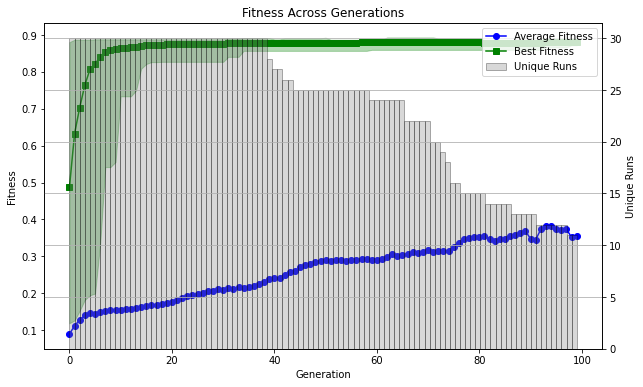

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with columns 'Generation', 'Fitness', 'Experiment name', and 'Run number'

# Step 1: Group by 'Experiment name', 'Run number', and 'Generation', and compute the mean and max fitness for each group
fitness_data = df.groupby(['Experiment name', 'Run number', 'Generation'])['Fitness'].agg(['mean', 'max']).reset_index()

# Step 2: Group by 'Generation' and compute the overall mean and max fitness for each generation
generation_stats = fitness_data.groupby('Generation').agg({'mean': 'mean', 'max': 'mean', 'Run number': 'nunique'}).reset_index()
generation_stats.rename(columns={'Run number': 'Unique Runs'}, inplace=True)

# Step 3: Calculate highest and lowest fitness across all runs per generation from the max fitness data
highest_fitness = fitness_data.groupby('Generation')['max'].max().reset_index()
lowest_fitness = fitness_data.groupby('Generation')['max'].min().reset_index()

# Step 4: Plot the average fitness, best fitness, and the shadow for the range between highest and lowest fitness
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average fitness on the first y-axis
ax1.plot(generation_stats['Generation'], generation_stats['mean'], marker='o', linestyle='-', color='b', label='Average Fitness')
ax1.plot(generation_stats['Generation'], generation_stats['max'], marker='s', linestyle='-', color='g', label='Best Fitness')
ax1.fill_between(generation_stats['Generation'], lowest_fitness['max'], highest_fitness['max'], alpha=0.3, color='g')

ax1.set_xlabel('Generation')
ax1.set_ylabel('Fitness')
ax1.set_title('Fitness Across Generations')

# Create a secondary y-axis for the histogram
ax2 = ax1.twinx()

# Plot transparent histogram for unique runs on the secondary y-axis
ax2.hist(generation_stats['Generation'], bins=len(generation_stats), alpha=0.3, color='gray', edgecolor='black',
         weights=generation_stats['Unique Runs'], label='Unique Runs')
ax2.set_ylabel('Unique Runs')

# Combine the legends from both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

plt.grid(True)
plt.show()


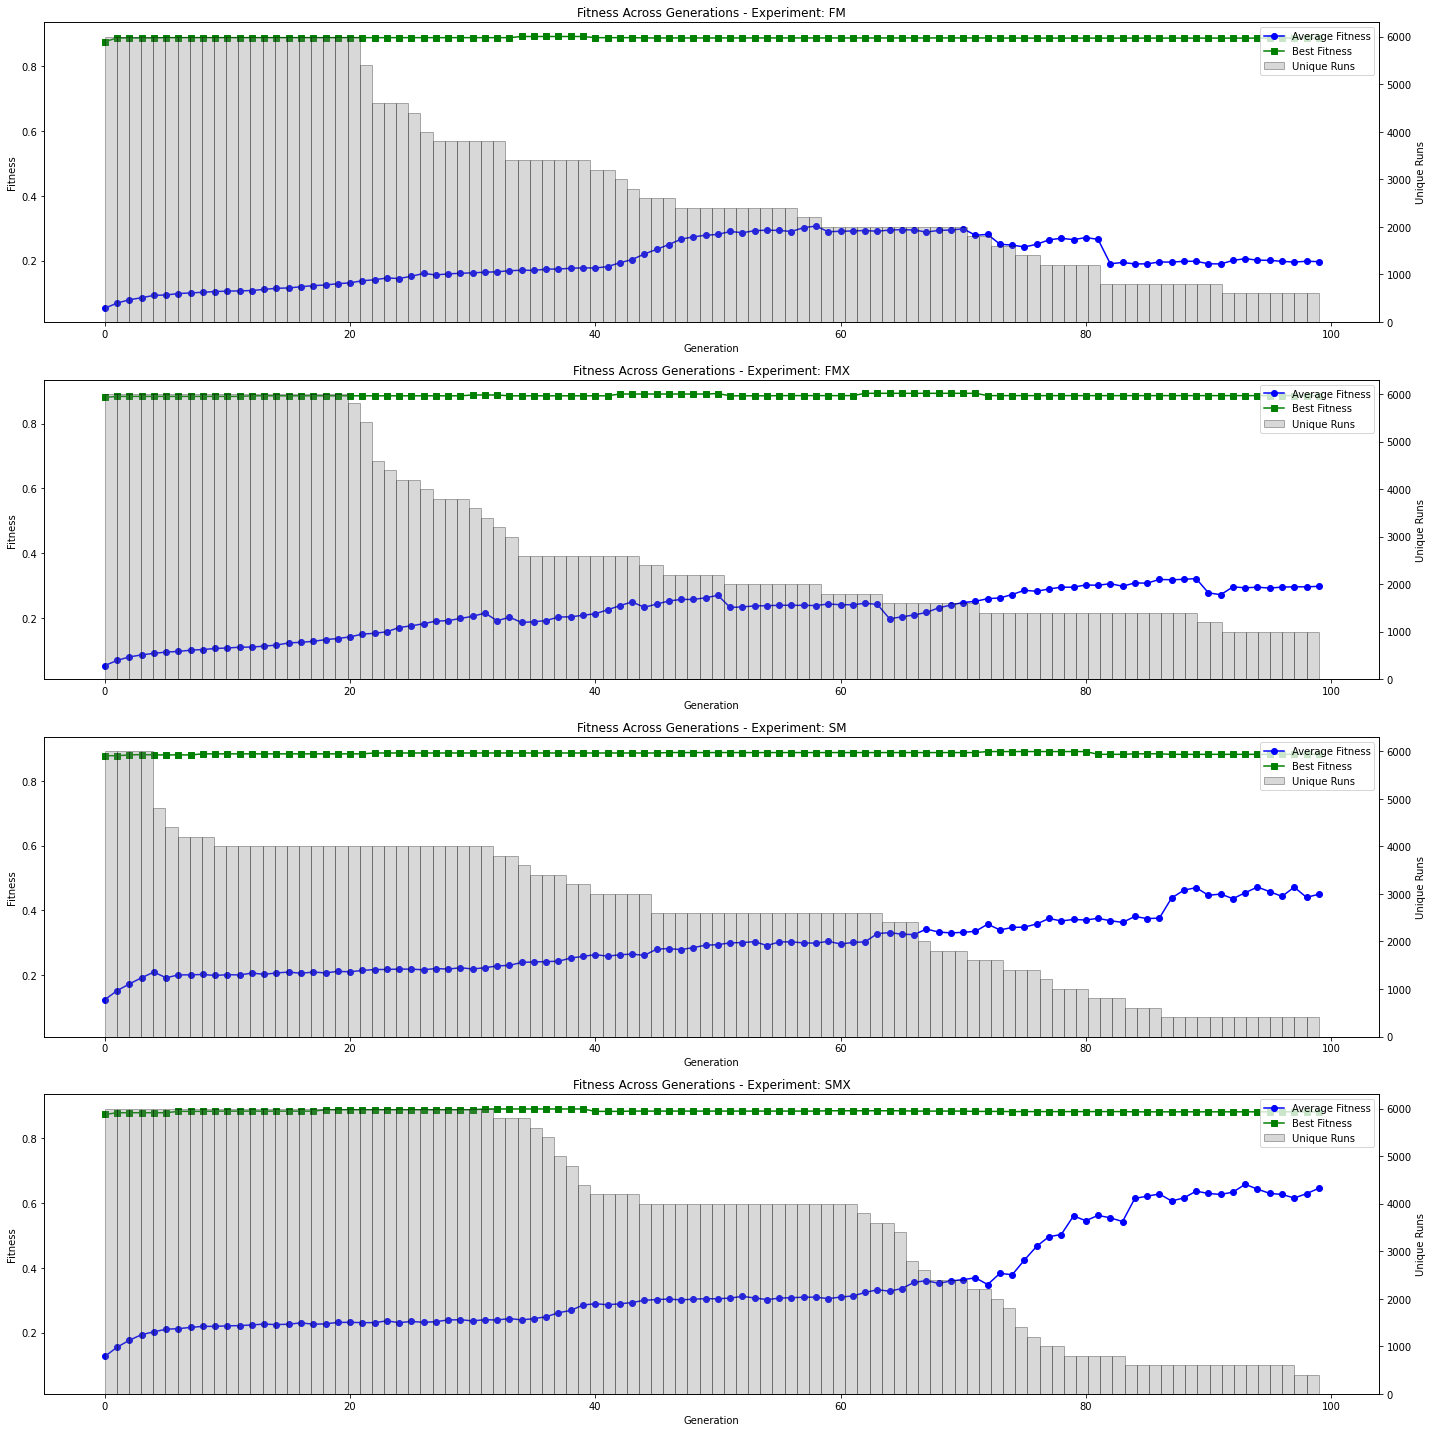

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
plt.rcParams["figure.figsize"] = [20, 100]
# Assuming you have a DataFrame 'df' with columns 'Generation', 'Fitness', 'Experiment name', and 'Run number'

# Step 1: Group by 'Experiment name', 'Run number', and 'Generation', and compute the mean and max fitness for each group
#fitness_data = df.groupby(['Experiment name', 'Run number', 'Generation'])['Fitness'].agg(['mean', 'max']).reset_index()

# Step 2: Group by 'Generation' and compute the overall mean and max fitness for each generation
#generation_stats = fitness_data.groupby(['Experiment name', 'Generation']).agg({'mean': 'mean', 'max': 'mean', 'Run number': 'nunique'}).reset_index()
#generation_stats.rename(columns={'Run number': 'Unique Runs'}, inplace=True)

# Step 3: Calculate highest and lowest fitness across all runs per generation from the max fitness data
#highest_fitness = fitness_data.groupby(['Experiment name', 'Generation'])['max'].max().reset_index()
#lowest_fitness = fitness_data.groupby(['Experiment name', 'Generation'])['max'].min().reset_index()

# Step 4: Create subplots for each experiment with a shared y-axis
experiment_names = df['Experiment name'].unique()
fig, axs = plt.subplots(len(experiment_names), figsize=(20, 20), sharey=True)  # sharey=True ensures shared y-axis

for i, experiment_name in enumerate(experiment_names):
    df_i = df[df['Experiment name'] == experiment_name]
    ax = axs[i]

    mean_fitness_generation = df_i.groupby(['Generation']).agg({'Fitness': 'mean'}).reset_index()
    max_fitness_generation = df_i.groupby(['Generation']).agg({'Fitness': 'max'}).reset_index()
    count_runs_generation = df_i.groupby(['Generation']).agg({'Run number': 'count'}).reset_index()
    # Plot average fitness on the first y-axis
    ax.plot(mean_fitness_generation['Generation'], mean_fitness_generation['Fitness'], marker='o', linestyle='-', color='b', label='Average Fitness')
    ax.plot(max_fitness_generation['Generation'], max_fitness_generation['Fitness'], marker='s', linestyle='-', color='g', label='Best Fitness')
    #ax.fill_between(experiment_data['Generation'], experiment_lowest['max'], experiment_highest['max'], alpha=0.3, color='g')
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.set_title(f'Fitness Across Generations - Experiment: {experiment_name}')
    
    # Create a secondary y-axis for the histogram
    ax2 = ax.twinx()
    
    # Plot transparent histogram for unique runs on the secondary y-axis
    ax2.hist(count_runs_generation['Generation'], bins=len(count_runs_generation), alpha=0.3, color='gray', edgecolor='black',
             weights=count_runs_generation['Run number'], label='Unique Runs')
    ax2.set_ylabel('Unique Runs')
    
    # Combine the legends from both y-axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2)

plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



df_mean_fitness = df.groupby(['Experiment name', 'Run number']).agg({'Generation': 'max'}).reset_index()

last_gen_stats = {'Experiment name': [], "Fitness": [], "Generation": []}
for i, data in df_mean_fitness.iterrows():
    #print(data)
    last_gen_stats['Experiment name'].append(data['Experiment name'])
    last_gen_stats['Fitness'].append(np.mean(df[(df['Generation'] == data['Generation']) & (df['Experiment name'] == data['Experiment name']) & (df['Run number'] == data['Run number'])]['Fitness']))
    last_gen_stats['Generation'].append(data['Generation'])

df_mean_fitness = pd.DataFrame(last_gen_stats)

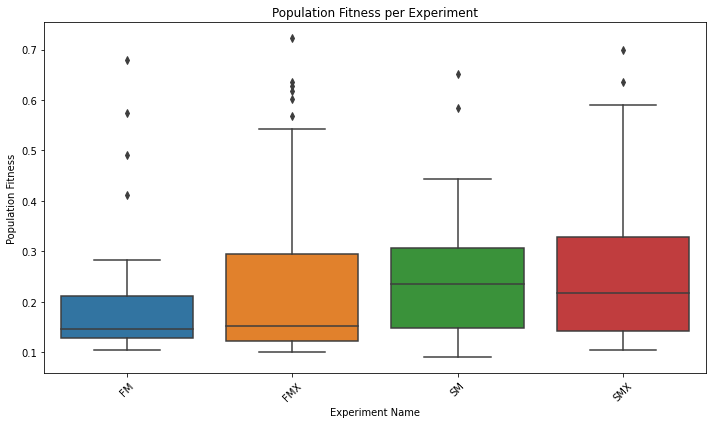

Experiment: FM 0.2057300450624898
Experiment: FMX 0.26276663758729896
Experiment: SM 0.24536093112174423
Experiment: SMX 0.25781790820385014


In [9]:

# Step 1: Create a box plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Use seaborn to create a box plot, specifying 'x' as 'Experiment name' and 'y' as 'Fitness'
sns.boxplot(data=df_mean_fitness, x='Experiment name', y='Fitness')

# Customize the plot
plt.title('Population Fitness per Experiment')
plt.xlabel('Experiment Name')
plt.ylabel('Population Fitness')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
#plt.tight_layout()
#plt.show()

# Set custom y-axis limits (adjust these values as needed)
#plt.ylim(0.8, 0.93)  # Example: set the y-axis limits from 0 to 100

# Show the plot
plt.tight_layout()
plt.show()
for i, experiment_name in enumerate(experiment_names):
    df_i = df_mean_fitness[df_mean_fitness['Experiment name'] == experiment_name]
    print(f"Experiment: {experiment_name} {np.mean(df_i['Fitness'])}")


  Experiment name Run number   Fitness
0              FM      run_1  0.883911
1              FM     run_10  0.876889
2              FM     run_11  0.873578
3              FM     run_12  0.885911
4              FM     run_13  0.873356


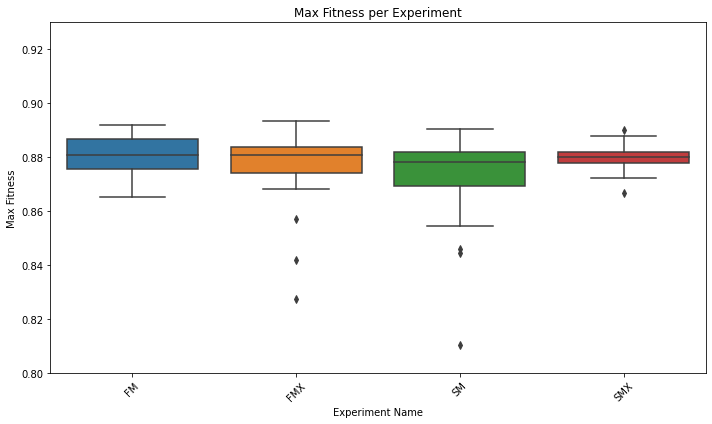

Experiment: FM Mean: 0.8809377749760946 Max: 0.8920221924781799
Experiment: FMX Mean: 0.8767074088255564 Max: 0.8935111165046692
Experiment: SM Mean: 0.8657400012016296 Max: 0.8905777931213379
Experiment: SMX Mean: 0.8800088942050934 Max: 0.8902888894081116


In [10]:


# Assuming you have a DataFrame 'df' with columns 'Experiment name', 'Run number', and 'Fitness'
df_max_fitness = df.groupby(['Experiment name', 'Run number']).agg({'Fitness': 'max'}).reset_index()
print(df_max_fitness.head(5))
# Step 1: Create a box plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Use seaborn to create a box plot, specifying 'x' as 'Experiment name' and 'y' as 'Fitness'
sns.boxplot(data=df_max_fitness, x='Experiment name', y='Fitness')

# Customize the plot
plt.title('Max Fitness per Experiment')
plt.xlabel('Experiment Name')
plt.ylabel('Max Fitness')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
#plt.tight_layout()
#plt.show()

# Set custom y-axis limits (adjust these values as needed)
plt.ylim(0.8, 0.93)  # Example: set the y-axis limits from 0 to 100

# Show the plot
plt.tight_layout()
plt.show()
for i, experiment_name in enumerate(experiment_names):
    df_i = df_max_fitness[df_max_fitness['Experiment name'] == experiment_name]
    print(f"Experiment: {experiment_name} Mean: {np.mean(df_i['Fitness'])} Max: {np.max(df_i['Fitness'])}")


  Experiment name Run number  Smart Phenotype
0              FM      run_1              280
1              FM     run_10              356
2              FM     run_11              131
3              FM     run_12              180
4              FM     run_13              247


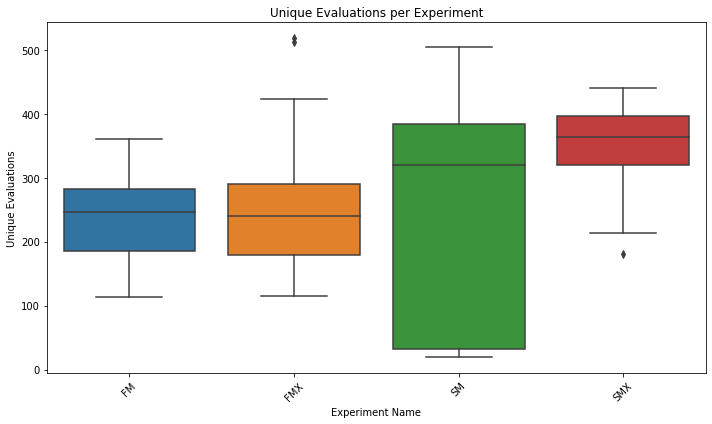

In [11]:
# Assuming you have a DataFrame 'df' with columns 'Experiment name', 'Run number', and 'Fitness'
df_unique_evals = df[df['Fitness'] >= 0.11].groupby(['Experiment name', 'Run number']).agg({'Smart Phenotype': 'nunique'}).reset_index()
print(df_unique_evals.head(5))
# Step 1: Create a box plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Use seaborn to create a box plot, specifying 'x' as 'Experiment name' and 'y' as 'Fitness'
sns.boxplot(data=df_unique_evals, x='Experiment name', y='Smart Phenotype')

# Customize the plot
plt.title('Unique Evaluations per Experiment')
plt.xlabel('Experiment Name')
plt.ylabel('Unique Evaluations')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
#plt.tight_layout()
#plt.show()

# Set custom y-axis limits (adjust these values as needed)
#plt.ylim(0.8, 0.93)  # Example: set the y-axis limits from 0 to 100

# Show the plot
plt.tight_layout()
plt.show()
#for i, experiment_name in enumerate(experiment_names):
    #df_i = df_max_fitness[df_max_fitness['Experiment name'] == experiment_name]
    #print(f"{experiment_name} {np.mean(df_i['Fitness'])}")


  Experiment name Run number  Smart Phenotype
0              FM      run_1               19
1              FM     run_10              170
2              FM     run_11               17
3              FM     run_12               47
4              FM     run_13               24


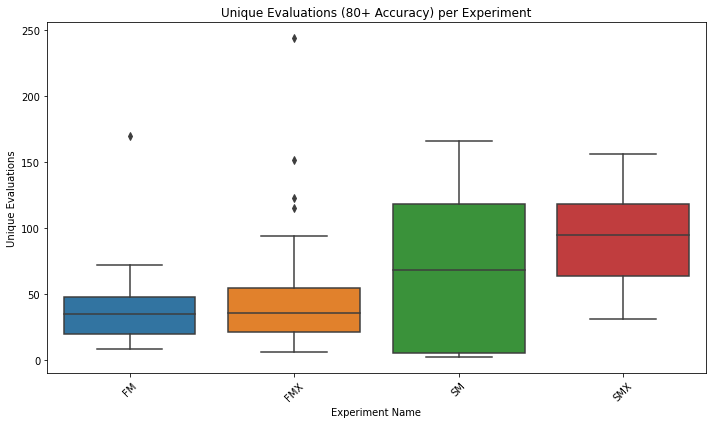

FM 38.733333333333334
FMX 52.1
SM 68.13333333333334
SMX 91.76666666666667


In [12]:
# Assuming you have a DataFrame 'df' with columns 'Experiment name', 'Run number', and 'Fitness'
df_unique_evals = df[df['Fitness'] >= 0.5].groupby(['Experiment name', 'Run number']).agg({'Smart Phenotype': 'nunique'}).reset_index()
print(df_unique_evals.head(5))
# Step 1: Create a box plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Use seaborn to create a box plot, specifying 'x' as 'Experiment name' and 'y' as 'Fitness'
sns.boxplot(data=df_unique_evals, x='Experiment name', y='Smart Phenotype')

# Customize the plot
plt.title('Unique Evaluations (80+ Accuracy) per Experiment')
plt.xlabel('Experiment Name')
plt.ylabel('Unique Evaluations')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
#plt.tight_layout()
#plt.show()

# Set custom y-axis limits (adjust these values as needed)
#plt.ylim(0.8, 0.93)  # Example: set the y-axis limits from 0 to 100

# Show the plot
plt.tight_layout()
plt.show()
for i, experiment_name in enumerate(experiment_names):
    df_i = df_unique_evals[df_unique_evals['Experiment name'] == experiment_name]
    print(f"{experiment_name} {np.mean(df_i['Smart Phenotype'])}")

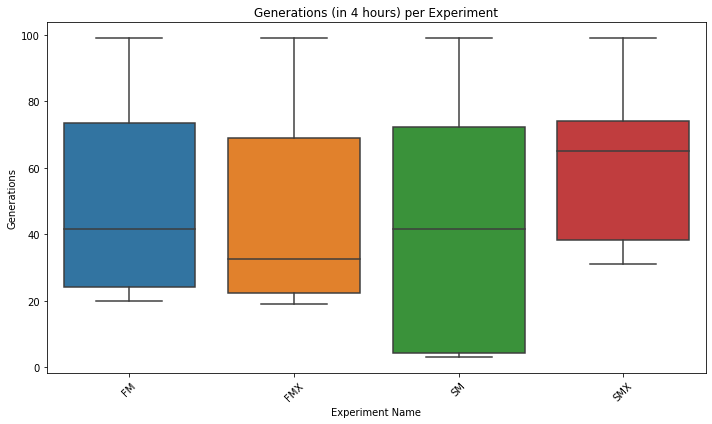

FM 49.166666666666664
FMX 47.733333333333334
SM 43.53333333333333
SMX 61.733333333333334


In [13]:
# Step 1: Create a box plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Use seaborn to create a box plot, specifying 'x' as 'Experiment name' and 'y' as 'Fitness'
sns.boxplot(data=df_mean_fitness, x='Experiment name', y='Generation')

# Customize the plot
plt.title('Generations (in 4 hours) per Experiment')
plt.xlabel('Experiment Name')
plt.ylabel('Generations')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
#plt.tight_layout()
#plt.show()

# Set custom y-axis limits (adjust these values as needed)
#plt.ylim(0.8, 0.93)  # Example: set the y-axis limits from 0 to 100

# Show the plot
plt.tight_layout()
plt.show()
for i, experiment_name in enumerate(experiment_names):
    df_i = df_mean_fitness[df_unique_evals['Experiment name'] == experiment_name]
    print(f"{experiment_name} {np.mean(df_i['Generation'])}")

In [14]:
data = process_results(results, run_number=run_number)

NameError: name 'process_results' is not defined

: 

In [ ]:
columns, rows = (40, 10)
plt.rcParams['figure.figsize'] = [columns, rows]
plot_fit(data["epochs"], data['averages_all'], data['bests_all'])

fit_floor = 0.0
fit_ceil = 1.0
gen_floor = 0.0
gen_ceil = float(len(data['epochs']))
pop_density_heatmap(data["indivs_epochs"], data["indivs"], rows=rows, columns=columns, fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil)
unique_indivs_heatmap(data["indivs_epochs"], data["indivs"], rows=rows, columns=columns, fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil)


In [ ]:
archive_list = []
for i in run_number: 
    it = 1 
    try:
        while True:
            archive = load_archive(path, i, it)
            it += 1
    except:
        pass
    try:
        print(f"loading archive {it - 1} for run {i}")
        archive = load_archive(path, i, it - 1)
        for x in archive:
            if 'fitness' in archive[x]:
                archive_list.append([x, archive[x], archive[x]['fitness'], i])
    except:
        print(f"Run {i} has no archive")
archive_list.sort(key=lambda x : x[2])



In [ ]:
archive_list
with open('data.json', 'w') as f:
    json.dump(archive_list, f)

In [ ]:
it = 0
while it < 10:
    print(archive_list[it])
    it+=1

In [ ]:
def turn_to_expr(phenotype, tree):
    if phenotype == "":
        return tree
    
    if phenotype[0:9] == "multiply(":
        #print("multiply")
        phenotype = phenotype[9:]
        node = Node("*", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:14] == "divide_no_nan(":
        phenotype = phenotype[14:]
        node = Node("/", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:4] == "add(":
        phenotype = phenotype[4:]
        node = Node("+", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:4] == "pow(":
        phenotype = phenotype[4:]
        node = Node("^", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:9] == "subtract(":
        phenotype = phenotype[9:]
        node = Node("-", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:4] == "grad":
        phenotype = phenotype[4:]
        node = Node("grad", tree, 0)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:4] == "beta":
        phenotype = phenotype[4:]
        node = Node("beta", tree, 0)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:5] == "alpha":
        phenotype = phenotype[5:]
        node = Node("alpha", tree, 0)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:5] == "sigma":
        phenotype = phenotype[5:]
        node = Node("sigma", tree, 0)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:9] == "negative(":
        phenotype = phenotype[9:]
        node = Node("-", tree, 1)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:5] == "sqrt(":
        phenotype = phenotype[5:]
        node = Node("sqrt", tree, 1)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:7] == "square(":
        phenotype = phenotype[7:]
        node = Node("square", tree, 1)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:2] == ", ":
        phenotype = phenotype[2:]
        return turn_to_expr(phenotype, tree)     
    elif phenotype[0] == ")":
        phenotype = phenotype[1:]
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:9] == "constant(":
        if phenotype[9:12] == "0.0" or phenotype[9:13] == "1.0)" or phenotype[9:13] == "1.0,":
            node = Node(phenotype[9:12], tree, 0)
            phenotype = phenotype[12:]
            tree.insert(node)
            tree = tree.get_next()           
        else:
            node = Node(phenotype[9:9+14], tree, 0)
            phenotype = phenotype[9+14:]
            tree.insert(node)
            tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    else:
        raise Exception(phenotype)
        
def math_phenotype(phenotype):
    functions = trim_phenotype(phenotype)
    alpha_func_string = functions[1][8:-2]
    beta_func_string =functions[2][14:-2] 
    sigma_func_string =functions[3][21:-2] 
    grad_func_string = functions[-1][21:]
    
    for x in [alpha_func_string, beta_func_string, sigma_func_string, grad_func_string]:
        print(x)    
        turn_to_expr(x, Node("", None, 1)).to_string()

    return grad_func_string

for indiv in data['indivs']:
    math_phenotype(indiv['phenotype'])

In [ ]:
a = "multiply("
print(a[0:9])
print(a[9:])

In [ ]:
from copy import deepcopy
import csv
from pickle import NONE
from utils.data_functions import load_fashion_mnist_training, load_cifar10_training, load_mnist_training, select_fashion_mnist_training
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

from keras.models import load_model
from tensorflow import keras
from keras import backend as K
from optimizers.custom_optimizer import CustomOptimizer
import datetime
experiment_time = datetime.datetime.now()

cached_dataset = None
cached_model = None

def train_model_tensorflow_cifar10(phen_params):
    phen, params = phen_params
    validation_size = params['VALIDATION_SIZE']
    fitness_size =params['FITNESS_SIZE'] 
    batch_size = params['BATCH_SIZE']
    epochs = params['EPOCHS']
    patience = params['PATIENCE']

    # Note that globals are borderline -- consider an object or a closure 
    # deliberately using globals() to make it ugly...
    if globals()['cached_dataset'] == None:
        globals()['cached_dataset'] = load_cifar10_training(validation_size=validation_size, test_size=fitness_size)
    
    if globals()['cached_model'] == None:
        globals()['cached_model'] = load_model(params['MODEL'], compile=False)
        
    # we assume validation and test sets are deterministic
    dataset = globals()['cached_dataset'] 
    model = tf.keras.models.clone_model(globals()['cached_model'])

    weights = model.get_weights()
    model.set_weights(weights)  

    # optimizer is constant aslong as phen doesn't changed?
    # -> opportunity to cache opt and compiled model
    opt = CustomOptimizer(phen=phen, model=model)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)

    score = model.fit(dataset['x_train'], dataset['y_train'],
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(dataset['x_val'], dataset['y_val']),
        validation_steps= validation_size // batch_size,
        callbacks=[
            early_stop
        ])

    K.clear_session()
    results = {}
    for metric in score.history:
        results[metric] = []
        for n in score.history[metric]:
            results[metric].append(n)
    test_score = model.evaluate(x=dataset['x_test'],y=dataset["y_test"], verbose=0, callbacks=[keras.callbacks.History()])
    return test_score[-1], results
